In [2]:
# start ollama server
# !ollama serve

In [3]:
# download to:  ~/.ollama/models
#!ollama pull nomic-embed-text
# !ollama pull llama3.1:8b
!ollama list

Error: could not connect to ollama app, is it running?


In [4]:
#!ollama help
# !ollama rm llama3:latest
#ollama run llama3.1

In [5]:
import os
from langchain_openai import AzureChatOpenAI #, AzureOpenAIEmbeddings
from dotenv import load_dotenv

load_dotenv()

llm = AzureChatOpenAI(
    openai_api_base=os.getenv("OPENAI_URL"),
    openai_api_version="2024-02-15-preview",
    openai_api_type="azure",
    temperature=0.2,
    openai_api_key=os.getenv("OPENAI_API_KEY")
)

In [6]:
# from langchain_ollama import ChatOllama

# llm = ChatOllama(
#     model="llama3.1:8b",
#     temperature=0.3,
# )

In [16]:
import sys
from pathlib import Path

sys.path.insert(0, '..') 

file_path = Path().cwd().parent / "sox.pdf"

from utils import get_text_from_pdf

document = get_text_from_pdf(file_path)
#print(document)

In [9]:
from pydantic import BaseModel, Field
from typing import Optional, List
from langchain_core.output_parsers import JsonOutputParser

class InsuredPerson(BaseModel):
    id: str = Field(description="Unique identifier for the insured person")
    insured_name: str = Field(description="Name of insured  person (VN); first and last name", examples=["Max Mustermann"])
    # insured_address: str = Field(description="Address of the person", examples=["Maxi Str.12, 12345 Berlin"]) 
    insured_phone_number: str = Field(description="Phone number of insured person (Telefonnummer)", examples=["+49 178 2837 2838"])
    insured_email: str = Field(description="Email of the person", examples=["max.mustermann@yahoo.de"])
    insured_policy_number: str = Field(description="Policy number (Vertragsnummer)", examples=["AS-9862471757"])

class Claimant(BaseModel):
    id: str = Field(description="Unique identifier for the claimant")
    name_claimant: str = Field(description="Name of the claimant", examples=["Max Mustermann"])
    phone_claimant: str = Field(description="Phone number of the claimant", examples=["+49 178 2837 2838"])
    email_claimant: str = Field(description="Email of the claimant", examples=["max.mustermann@gmx.de"])
    iban_claimant: str = Field(description="IBAN of the claimant", examples=["DE12345678901234567890"])

class Object(BaseModel):
    id: str = Field(description="Unique identifier for the object")
    object_type: str = Field(description="Object type", examples=["Handy"])
    cause_of_damage_obj: str = Field(description="Ursache des Schadens", examples=["Sturz"])
    info_obj: str = Field(description="Angaben zum beschädigten Gegenstand", examples=["Herstellungsjahr, Marke, Modell"])
    pred_claim_amount_obj: Optional[str] = Field(description="Voraussichtliche Schadenshöhe", examples=["1000€, Keine Angabe"])

class Location(BaseModel):
    id: str = Field(description="Unique identifier for the location")
    claims_description_location: str = Field(description="Beschreibung zum Schadenort", examples=["Arbeitsplatz"])
    address_details: str = Field(description="Address details of a person, e.g. insured, claimant. Straße / Hausnummer. PLZ / Ort. Land", examples=["Maxi Str.12, 12345 Berlin, Deutschland"])

class Links(BaseModel):
    id: str = Field(description="Unique identifier for the link")
    link_types: List[str] = Field(default_factory=list, description="List of links between nodes", examples=["WORKS_WITH", "LIVES_AT", "CLAIMS", "LOCATED_AT", "DAMAGED", "OWNS", "IS_RELATED_TO"])
    node_from: str = Field(description="Unique identifier of the node where the link starts")
    node_to: str = Field(description="Unique identifier of the node where the link ends")

class Nodes(BaseModel):
    insured: List[InsuredPerson] = Field(default_factory=list, description="List of insured person(s)")
    claimant: List[Claimant] = Field(default_factory=list, description="List of claimant(s)")
    object: List[Object] = Field(default_factory=list, description="List of involved/damaged objects")
    location: List[Location] = Field(default_factory=list, description="List of locations")

# Your parser initialization remains largely the same but now expects lists:
parser_node = JsonOutputParser(pydantic_object=Nodes)

parser_links = JsonOutputParser(pydantic_object=Links)

In [10]:
# from langchain_aws import ChatBedrock
from langchain_core.prompts import PromptTemplate
from langchain.chains import LLMChain
from pprint import PrettyPrinter

template = """
You are an expert in graph generation. Your task is to extract entities and their relationships from a given text.
Following is an insurance contract. 
Please extract the following information for the nodes / entities:\n{node_instructions}
Here is the text to extract from {context}.\n 
"""
 
prompt = PromptTemplate(
    template=template,
    input_variables=["context"],
    partial_variables={"node_instructions": parser_node.get_format_instructions()},
)
 
chain = prompt | llm | parser_node
# chain = LLMChain(llm=model, prompt=prompt, callbacks=[handler2], verbose=False, output_parser=parser)  # alternative way to define chain
  
response_nodes = chain.invoke({"context": document})
 
PrettyPrinter().pprint(response_nodes) 

{'claimant': [{'email_claimant': 'Keine Angaben',
               'iban_claimant': 'Keine Angaben',
               'id': '1',
               'name_claimant': 'Frau Siglinde Horn',
               'phone_claimant': '+49 1512 4413863'}],
 'insured': [{'id': '1',
              'insured_email': 'aidas.sugintas@gmail.com',
              'insured_name': 'Gabriele Sugintiene',
              'insured_phone_number': '+4915145958879',
              'insured_policy_number': 'AS-9862471757'}],
 'location': [{'address_details': 'Mehringerstr. 12b, 84489 Burghausen, '
                                  'Deutschland',
               'claims_description_location': 'Arbeitplatz',
               'id': '1'},
              {'address_details': 'Kettelerstrasse 4a, 84547 Emmerting, '
                                  'Deutschland',
               'claims_description_location': 'Schadenobjekt 1',
               'id': '2'}],
 'object': [{'cause_of_damage_obj': 'Sonstige Schadenursache',
             'id': '1',
 

In [11]:
template = """
You are an expert in graph generation. Your task is to extract links/relationships from a given text {context}.
Please extract the relationships in the text as:\n{link_instructions}.
"""
 
prompt = PromptTemplate(
    template=template,
    input_variables=["context"],
    partial_variables={"link_instructions": parser_links.get_format_instructions()},
)
 
chain = prompt | llm | parser_links
# chain = LLMChain(llm=model, prompt=prompt, callbacks=[handler2], verbose=False, output_parser=parser)  # alternative way to define chain
  
response_edges = chain.invoke({"context": document})
 
PrettyPrinter().pprint(response_edges) 

[{'id': '1',
  'link_types': ['LOCATED_AT'],
  'node_from': 'Schadenort',
  'node_to': 'Arbeitplatz'},
 {'id': '2',
  'link_types': ['LOCATED_AT'],
  'node_from': 'Arbeitplatz',
  'node_to': 'Mehringerstr. 12b, 84489 Burghausen, Deutschland'},
 {'id': '3',
  'link_types': ['CLAIMS'],
  'node_from': 'Gabriele Sugintiene',
  'node_to': 'Schadenmeldung'},
 {'id': '4',
  'link_types': ['OWNS'],
  'node_from': 'Gabriele Sugintiene',
  'node_to': 'Vertragsnummer AS-9862471757'},
 {'id': '5',
  'link_types': ['DAMAGED'],
  'node_from': 'Gabriele Sugintiene',
  'node_to': 'Handy'},
 {'id': '6',
  'link_types': ['OWNS'],
  'node_from': 'Siglinde Horn',
  'node_to': 'Handy'},
 {'id': '7',
  'link_types': ['LIVES_AT'],
  'node_from': 'Siglinde Horn',
  'node_to': 'Kettelerstrasse 4a, 84547 Emmerting, Deutschland'},
 {'id': '8',
  'link_types': ['WORKS_WITH'],
  'node_from': 'Gabriele Sugintiene',
  'node_to': 'Siglinde Horn'},
 {'id': '9',
  'link_types': ['IS_RELATED_TO'],
  'node_from': 'Gabrie

In [12]:
import networkx as nx

G = nx.Graph() 

for node_type, attributes in response_nodes.items():
    for attribute in attributes:
        print(f"{node_type}: {attribute}")
        print()
        G.add_node(f"{node_type}_{attribute["id"]}", **attribute)

insured: {'id': '1', 'insured_name': 'Gabriele Sugintiene', 'insured_phone_number': '+4915145958879', 'insured_email': 'aidas.sugintas@gmail.com', 'insured_policy_number': 'AS-9862471757'}

claimant: {'id': '1', 'name_claimant': 'Frau Siglinde Horn', 'phone_claimant': '+49 1512 4413863', 'email_claimant': 'Keine Angaben', 'iban_claimant': 'Keine Angaben'}

object: {'id': '1', 'object_type': 'Handy / Tablet', 'cause_of_damage_obj': 'Sonstige Schadenursache', 'info_obj': 'Hersteller / Produktbezeichnung: Keine Angaben, Alter des Geräts: Älter als 2 Jahre, Angaben zum beschädigten Gegenstand: Display', 'pred_claim_amount_obj': 'Keine Angaben'}

location: {'id': '1', 'claims_description_location': 'Arbeitplatz', 'address_details': 'Mehringerstr. 12b, 84489 Burghausen, Deutschland'}

location: {'id': '2', 'claims_description_location': 'Schadenobjekt 1', 'address_details': 'Kettelerstrasse 4a, 84547 Emmerting, Deutschland'}



In [13]:
import networkx as nx

# Assuming G is already initialized as a graph
G = nx.Graph()

# Simplified loop to handle links creation and graph population
links = []  # Holds all link dictionaries
for edge in response_edges:
    # Create a link dictionary from edge data
    link = {
        "id": edge["id"],
        "link_types": edge["link_types"],  # No need to wrap this in another list if it's already correct
        "node_from": edge["node_from"],
        "node_to": edge["node_to"]
    }
    links.append(link)

    # Add edges to the graph for each link type in this edge
    for link_type in edge['link_types']:
        G.add_edge(edge['node_from'], edge['node_to'], relationship=link_type)

# Display structured links data
PrettyPrinter().pprint(links)

# Optionally print graph edges to verify
print("Graph edges:")
print(list(G.edges(data=True)))


[{'id': '1',
  'link_types': ['LOCATED_AT'],
  'node_from': 'Schadenort',
  'node_to': 'Arbeitplatz'},
 {'id': '2',
  'link_types': ['LOCATED_AT'],
  'node_from': 'Arbeitplatz',
  'node_to': 'Mehringerstr. 12b, 84489 Burghausen, Deutschland'},
 {'id': '3',
  'link_types': ['CLAIMS'],
  'node_from': 'Gabriele Sugintiene',
  'node_to': 'Schadenmeldung'},
 {'id': '4',
  'link_types': ['OWNS'],
  'node_from': 'Gabriele Sugintiene',
  'node_to': 'Vertragsnummer AS-9862471757'},
 {'id': '5',
  'link_types': ['DAMAGED'],
  'node_from': 'Gabriele Sugintiene',
  'node_to': 'Handy'},
 {'id': '6',
  'link_types': ['OWNS'],
  'node_from': 'Siglinde Horn',
  'node_to': 'Handy'},
 {'id': '7',
  'link_types': ['LIVES_AT'],
  'node_from': 'Siglinde Horn',
  'node_to': 'Kettelerstrasse 4a, 84547 Emmerting, Deutschland'},
 {'id': '8',
  'link_types': ['WORKS_WITH'],
  'node_from': 'Gabriele Sugintiene',
  'node_to': 'Siglinde Horn'},
 {'id': '9',
  'link_types': ['IS_RELATED_TO'],
  'node_from': 'Gabrie

14


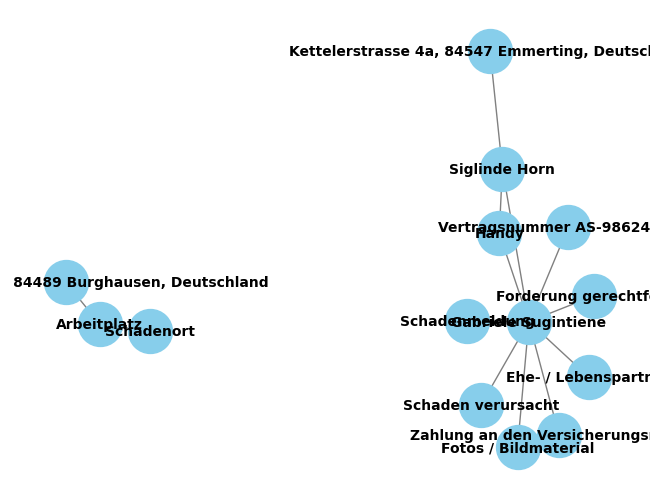

In [14]:
print(G.number_of_nodes())

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1000, edge_color='gray', font_size=10, font_weight='bold')


# Version 2:

In [24]:
from pydantic import BaseModel, Field
from typing import Optional, List
from langchain_core.output_parsers import JsonOutputParser

class InsuredPerson(BaseModel):
    id: str = Field(description="Unique identifier for the insured person", alias="insured_id")
    insured_name: str = Field(description="Name of insured  person (VN); first and last name", examples=["Max Mustermann"], alias="insured_name")
    insured_phone_number: str = Field(description="Phone number of insured person (Telefonnummer)", examples=["+49 178 2837 2838"], alias="insured_phone_number")
    insured_email: str = Field(description="Email of the person", examples=["max.mustermann@yahoo.de"], alias="insured_email")
    insured_policy_number: str = Field(description="Policy number (Vertragsnummer)", examples=["AS-9862471757"], alias="insured_policy_number")

class Claimant(BaseModel):
    id: str = Field(description="Unique identifier for the claimant", alias="claimant_id")
    name_claimant: str = Field(description="Name of the claimant", examples=["Max Mustermann"], alias="claimant_name")
    phone_claimant: str = Field(description="Phone number of the claimant", examples=["+49 178 2837 2838"], alias="claimant_phone_number")
    email_claimant: str = Field(description="Email of the claimant", examples=["max.mustermann@gmx.de"], alias="claimant_email")
    iban_claimant: str = Field(description="IBAN of the claimant", examples=["DE12345678901234567890"], alias="claimant_iban")

class Object(BaseModel):
    id: str = Field(description="Unique identifier for the object", alias="object_id")
    object_type: str = Field(description="Object type", examples=["Handy"], alias="object_type")
    cause_of_damage_obj: str = Field(description="Ursache des Schadens", examples=["Sturz"], alias="cause_of_damage_obj")
    info_obj: str = Field(description="Angaben zum beschädigten Gegenstand", examples=["Herstellungsjahr, Marke, Modell"], alias="info_obj")
    pred_claim_amount_obj: Optional[str] = Field(description="Voraussichtliche Schadenshöhe", examples=["1000€, Keine Angabe"], alias="pred_claim_amount_obj")

class Location(BaseModel):
    id: str = Field(description="Unique identifier for the location", alias="location_id")
    claims_description_location: str = Field(description="Beschreibung zum Schadenort", examples=["Arbeitsplatz"], alias="claims_description_location")
    address_details: str = Field(description="Address details of a person, e.g. insured, claimant. Straße / Hausnummer. PLZ / Ort. Land", examples=["Maxi Str.12, 12345 Berlin, Deutschland"], alias="address_details")

class Links(BaseModel):
    id: str = Field(description="Unique identifier for the link", alias="link_id")
    link_types: List[str] = Field(default_factory=list, description="List of links between nodes", examples=["WORKS_WITH", "LIVES_AT", "CLAIMS", "LOCATED_AT", "DAMAGED", "OWNS", "IS_RELATED_TO"])
    node_from: str = Field(description="Node alias where the link starts", alias="node_from", examples=["insured_id", "claimant_id", "object_id", "location_id"])
    node_to: str = Field(description="Node alias where the link ends", alias="node_to", examples=["claimant_id", "object_id", "location_id"])

class Nodes(BaseModel):
    insured: List[InsuredPerson] = Field(default_factory=list, description="List of insured person(s)", alias="insured")
    claimant: List[Claimant] = Field(default_factory=list, description="List of claimant(s)", alias="claimant")
    object: List[Object] = Field(default_factory=list, description="List of involved/damaged objects", alias="object")
    location: List[Location] = Field(default_factory=list, description="List of locations", alias="location")

class OutputStructure(BaseModel):
    nodes: Nodes
    edges: Links
 
parser = JsonOutputParser(pydantic_object=OutputStructure)


In [37]:
# from langchain_aws import ChatBedrock
from langchain_core.prompts import PromptTemplate
from langchain.chains import LLMChain
from pprint import PrettyPrinter

template = """
You are an expert in graph generation. Your task is to extract entities and their relationships from a given text. 
Please extract the information as:\n{instructions}
Following is a claims document to extract information from {context}.
"""
 
prompt = PromptTemplate(
    template=template,
    input_variables=["context"],
    partial_variables={"instructions": parser.get_format_instructions()},
)
 
chain = prompt | llm | parser
  
response = chain.invoke({"context": document})
 
PrettyPrinter().pprint(response) 

{'edges': [{'link_id': '1',
            'link_types': ['CLAIMS'],
            'node_from': 'insured_id',
            'node_to': 'claimant_id'},
           {'link_id': '2',
            'link_types': ['DAMAGED'],
            'node_from': 'insured_id',
            'node_to': 'object_id'},
           {'link_id': '3',
            'link_types': ['LOCATED_AT'],
            'node_from': 'insured_id',
            'node_to': 'location_id'},
           {'link_id': '4',
            'link_types': ['LOCATED_AT'],
            'node_from': 'claimant_id',
            'node_to': 'location_id'},
           {'link_id': '5',
            'link_types': ['IS_RELATED_TO'],
            'node_from': 'insured_id',
            'node_to': 'claimant_id'}],
 'nodes': {'claimant': [{'claimant_email': 'Keine Angaben',
                         'claimant_iban': 'Keine Angaben',
                         'claimant_id': '1',
                         'claimant_name': 'Frau Siglinde Horn',
                         'claimant_p

In [40]:
response['nodes'].keys()
# Visualize in networkx 
#G = nx.Graph()




dict_keys(['insured', 'claimant', 'location', 'object'])

In [36]:
# Visualize in networkx
G = nx.Graph()

for node_type, attributes in response_nodes.items():
    for attribute in attributes:
        print(f"{node_type}: {attribute}")
        print()
        G.add_node(f"{node_type}_{attribute["id"]}", **attribute)
        
        


nodes: insured



TypeError: string indices must be integers, not 'str'

In [34]:
from langchain_community.graphs import Neo4jGraph

url = "bolt://localhost:7687"  # Default local Neo4j URL
password = "neo4j_password"  # Set this to your database password

graph = Neo4jGraph(
    url=url,
    username="neo4j",
    password=password,
    database="sox",
)

graph.refresh_schema()

In [33]:
# Empty the database
graph.query("MATCH (n) DETACH DELETE n")

[]

In [35]:
# Add nodes
for node_type, attributes in response_nodes.items():
    for attribute in attributes:
        node_id = f"{node_type}_{attribute['id']}"
        graph.query(
            f"CREATE (n:{node_type} {{id: $id}}) SET n += $props",
            {"id": node_id, "props": attribute}
        )

TypeError: string indices must be integers, not 'str'

In [ ]:
example_output = [
   dict(
    title="Person",
    type="object",
    description="Node",
    properties=[
        dict(name="name", type="string", description="The name of the person", examples=["Tom Hanks"]),
        # dict(name="date_of_birth", column_name="person_dob", type="date", description="The date of birth for the person", examples=["1987-06-05"]),
        # dict(name="id", column_name="person_name, date_of_birth", type="string", description="The ID is a combination of name and date of birth to ensure uniqueness", examples=["tom-hanks-1987-06-05"]),
    ],
  ),
#    dict(
#     title="Director",
#     type="object",
#     description="Node",
#     properties=[
#         dict(name="name", column_name="director_names", type="string", description="The name of the directors. Split values in text by a comma", examples=["Francis Ford Coppola"]),
#     ],
#   ),
#    dict(
#     title="Movie",
#     type="object",
#     description="Node",
#     properties=[
#         dict(name="title", column_name="title", type="string", description="The title of the movie", examples=["Toy Story"]),
#         dict(name="released", column_name="released", type="integer", description="The year the movie was released", examples=["1990"]),
#     ],)
   dict(
    title="IS_FATHER_OF",
    type="object",
    description="Relationship",
    properties=[
        dict(name="_from", type="string", description="The Father", examples=["Person"]),
        dict(name="_to", type="string", description="The child", examples=["Person"]),
    ]
  )
#    dict(
#     title="DIRECTED",
#     type="object",
#     description="Relationship",
#     properties=[
#         dict(name="_from", type="string", column_name="director_names", description="Director names are comma separated", examples=["Director"]),
#         dict(name="_to", type="string", column_name="title", description="The label of the node this relationship ends at", examples=["Movie"]),
#     ],
#   ),
]

In [114]:
from pydantic import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser

class OutputStructure(BaseModel):
    input_text: str = Field(description="The input text")
    translated_text: str = Field(description="The translated text")
 
parser = JsonOutputParser(pydantic_object=OutputStructure)

In [115]:
from langchain.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate

system_template = """You are a helpful assistant that translates {input_language} to {output_language}.
{format_instructions}"""

human_template = "{text}"

system_message_prompt = SystemMessagePromptTemplate.from_template(system_template)
human_message_prompt = HumanMessagePromptTemplate.from_template(human_template)

chat_prompt = ChatPromptTemplate.from_messages([
    system_message_prompt,
    human_message_prompt
])

In [ ]:
from pprint import PrettyPrinter

prompt = chat_prompt.partial(
    format_instructions=parser.get_format_instructions(),
    input_language="English",
    output_language="German"
)

chain = prompt | llm | parser

result = chain.invoke({"text": "I love programming."})

PrettyPrinter().pprint(result) 

## Graph from text example:

In [153]:
from pydantic import BaseModel, Field

class JSONSchemaSpecification(BaseModel):
    notes: str = Field(description="Any notes or comments about the schema")
    jsonschema: str = Field(description="A JSON array of JSON schema specifications that describe the entities in the data model")

parser = JsonOutputParser(pydantic_object=JSONSchemaSpecification)

In [2]:
from pathlib import Path
from langchain_community.document_loaders import TextLoader

txt_path = Path().cwd().parent / "dune.txt"

loader = TextLoader(str(txt_path))
documents = loader.load()

In [ ]:
print(documents[0].page_content)

In [156]:
example_output = [
   dict(
    title="Person",
    type="object",
    description="Node",
    properties=[
        dict(name="name", type="string", description="The name of the person", examples=["Tom Hanks"]),
        # dict(name="date_of_birth", column_name="person_dob", type="date", description="The date of birth for the person", examples=["1987-06-05"]),
        # dict(name="id", column_name="person_name, date_of_birth", type="string", description="The ID is a combination of name and date of birth to ensure uniqueness", examples=["tom-hanks-1987-06-05"]),
    ],
  ),
#    dict(
#     title="Director",
#     type="object",
#     description="Node",
#     properties=[
#         dict(name="name", column_name="director_names", type="string", description="The name of the directors. Split values in text by a comma", examples=["Francis Ford Coppola"]),
#     ],
#   ),
#    dict(
#     title="Movie",
#     type="object",
#     description="Node",
#     properties=[
#         dict(name="title", column_name="title", type="string", description="The title of the movie", examples=["Toy Story"]),
#         dict(name="released", column_name="released", type="integer", description="The year the movie was released", examples=["1990"]),
#     ],)
   dict(
    title="IS_FATHER_OF",
    type="object",
    description="Relationship",
    properties=[
        dict(name="_from", type="string", description="The Father", examples=["Person"]),
        dict(name="_to", type="string", description="The child", examples=["Person"]),
    ]
  )
#    dict(
#     title="DIRECTED",
#     type="object",
#     description="Relationship",
#     properties=[
#         dict(name="_from", type="string", column_name="director_names", description="Director names are comma separated", examples=["Director"]),
#         dict(name="_to", type="string", column_name="title", description="The label of the node this relationship ends at", examples=["Movie"]),
#     ],
#   ),
]

In [ ]:
from langchain.prompts import PromptTemplate
from json import dumps

model_prompt = PromptTemplate.from_template("""
You are an expert Graph Database administrator.
Your task is to design a knowledge graph based on information provided in a raw text source.

You must identify in the text if a word indicates being a node/vertice or a link/relationship between two nodes. Consider:
* Does the text represent an entity, i.e. a node, like for example a Person, Place, or object?  If so, this should be a node.
* Does the text represent a relationship between two entities?  If so, this should be a relationship between two nodes.
                                            
This is the text from which you need to identify: {text}

Here is an example of an expected output:
{example_output}
""", partial_variables=dict(example_output=dumps(example_output)))

chain = model_prompt | llm | parser

In [160]:
result = chain.invoke({"text": documents[0].page_content})

# # Process all chunks in parallel using batch
# results = chain.batch([{"text": chunk.page_content} for chunk in documents], {"max_concurrency": 5})

# # Print the results
# for result in results:
#     PrettyPrinter().pprint(result) 

In [3]:
#PrettyPrinter().pprint(result)

In [10]:
from langchain_community.graphs import Neo4jGraph

url = "bolt://localhost:7687"  # Default local Neo4j URL
password = "neo4j_password"  # Set this to your database password

graph = Neo4jGraph(
    url=url,
    username="neo4j",
    password=password,
    database="dune-example",
)

In [11]:
from langchain_experimental.graph_transformers import LLMGraphTransformer

llm_transformer = LLMGraphTransformer(llm=llm)

In [ ]:
from langchain_core.documents import Document

text = """
Marie Curie, born in 1867, was a Polish and naturalised-French physicist and chemist who conducted pioneering research on radioactivity.
She was the first woman to win a Nobel Prize, the first person to win a Nobel Prize twice, and the only person to win a Nobel Prize in two scientific fields.
Her husband, Pierre Curie, was a co-winner of her first Nobel Prize, making them the first-ever married couple to win the Nobel Prize and launching the Curie family legacy of five Nobel Prizes.
She was, in 1906, the first woman to become a professor at the University of Paris.
"""

text = """Duke Leto Atreides of House Atreides, ruler of the ocean planet Caladan, is assigned by the Padishah Emperor Shaddam IV to serve as fief ruler of the planet Arrakis. Although Arrakis is a harsh and inhospitable desert planet, it is of enormous importance because it is the only planetary source of melange, or the "spice", a unique and incredibly valuable substance that extends human youth, vitality and lifespan. It is also through the consumption of spice that Spacing Guild Navigators are able to effect safe interstellar travel. Shaddam, jealous of Duke Leto Atreides's rising popularity in the Landsraad, sees House Atreides as a potential future rival and threat, so conspires with House Harkonnen, the former stewards of Arrakis and the longstanding enemies of House Atreides, to destroy Leto and his family after their arrival. Leto is aware his assignment is a trap of some kind, but is compelled to obey the Emperor's orders anyway.
Leto's concubine Lady Jessica is an acolyte of the Bene Gesserit, an exclusively female group that pursues mysterious political aims and wields seemingly superhuman physical and mental abilities, such as the ability to control their bodies down to the cellular level, and also decide the sex of their children. Though Jessica was instructed by the Bene Gesserit to bear a daughter as part of their breeding program, out of love for Leto she bore a son, Paul. From a young age, Paul has been trained in warfare by Leto's aides, the elite soldiers Duncan Idaho and Gurney Halleck. Thufir Hawat, the Duke's Mentat (human computers, able to store vast amounts of data and perform advanced calculations on demand), has instructed Paul in the ways of political intrigue. Jessica has also trained her son in Bene Gesserit disciplines.
Paul's prophetic dreams interest Jessica's superior, the Reverend Mother Gaius Helen Mohiam, who subjects Paul to the deadly gom jabbar test. Holding a poisonous needle to his neck ready to strike should he be unable to resist the impulse to withdraw his hand from the nerve induction box, she tests Paul's self-control to overcome the extreme psychological pain he is being subjected to through the box.
Leto, Jessica, and Paul travel with their household to occupy Arrakeen, the capital on Arrakis formerly held by House Harkonnen. Leto learns of the dangers involved in harvesting the spice, which is protected by giant sandworms, and seeks to negotiate with the planet's native Fremen people, seeing them as a valuable ally rather than foes. Soon after the Atreides's arrival, Harkonnen forces attack, joined by the Emperor's ferocious Sardaukar troops in disguise. Leto is betrayed by his personal physician, the Suk doctor Wellington Yueh, who delivers a drugged Leto to the Baron Vladimir Harkonnen and his twisted Mentat, Piter De Vries. Yueh, however, arranges for Jessica and Paul to escape into the desert, where they are presumed dead by the Harkonnens. Yueh replaces one of Leto's teeth with a poison gas capsule, hoping Leto can kill the Baron during their encounter. The Baron narrowly avoids the gas due to his shield, which kills Leto, De Vries, and the others in the room. The Baron forces Hawat to take over De Vries's position by dosing him with a long-lasting, fatal poison and threatening to withhold the regular antidote doses unless he obeys. While he follows the Baron's orders, Hawat works secretly to undermine the Harkonnens.
Having fled into the desert, Paul is exposed to high concentrations of spice and has visions through which he realizes he has significant powers (as a result of the Bene Gesserit breeding scheme). He foresees potential futures in which he lives among the planet's native Fremen before leading them on a Holy Jihad across the known universe.
It is revealed Jessica is the daughter of Baron Harkonnen, a secret kept from her by the Bene Gesserit. After being captured by Fremen, Paul and Jessica are accepted into the Fremen community of Sietch Tabr, and teach the Fremen the Bene Gesserit fighting technique known as the "weirding way". Paul proves his manhood by killing a Fremen named Jamis in a ritualistic crysknife fight and chooses the Fremen name Muad'Dib, while Jessica opts to undergo a ritual to become a Reverend Mother by drinking the poisonous Water of Life. Pregnant with Leto's daughter, she inadvertently causes the unborn child, Alia, to become infused with the same powers in the womb. Paul takes a Fremen lover, Chani, and has a son with her, Leto II.
Two years pass and Paul's powerful prescience manifests, which confirms for the Fremen that he is their prophesied messiah, a legend planted by the Bene Gesserit's Missionaria Protectiva. Paul embraces his father's belief that the Fremen could be a powerful fighting force to take back Arrakis, but also sees that if he does not control them, their jihad could consume the entire universe. Word of the new Fremen leader reaches both Baron Harkonnen and the Emperor as spice production falls due to their increasingly destructive raids. The Baron encourages his brutish nephew Glossu Rabban to rule with an iron fist, hoping the contrast with his shrewder nephew Feyd-Rautha will make the latter popular among the people of Arrakis when he eventually replaces Rabban. The Emperor, suspecting the Baron of trying to create troops more powerful than the Sardaukar to seize power, sends spies to monitor activity on Arrakis. Hawat uses the opportunity to sow seeds of doubt in the Baron about the Emperor's true plans, putting further strain on their alliance.
Gurney, having survived the Harkonnen coup becomes a smuggler, reuniting with Paul and Jessica after a Fremen raid on his harvester. Believing Jessica to be the traitor, Gurney threatens to kill her, but is stopped by Paul. Paul did not foresee Gurney's attack, and concludes he must increase his prescience by drinking the Water of Life, which is traditionally fatal to males. Paul falls into unconsciousness for three weeks after drinking the poison, but when he wakes, he has clairvoyance across time and space: he is the Kwisatz Haderach, the ultimate goal of the Bene Gesserit breeding program.
Paul senses the Emperor and Baron are amassing fleets around Arrakis to quell the Fremen rebellion, and prepares the Fremen for a major offensive against the Harkonnen troops. The Emperor arrives with the Baron on Arrakis. The Emperor's troops seize a Fremen outpost, killing many including young Leto II, while Alia is captured and taken to the Emperor. Under cover of an electric storm, which shorts out the Emperor's troops' defensive shields, Paul and the Fremen, riding giant sandworms, assault the capital while Alia assassinates the Baron and escapes. The Fremen quickly defeat both the Harkonnen and Sardaukar troops.
Paul faces the Emperor, threatening to destroy spice production forever unless Shaddam abdicates the throne. Feyd-Rautha attempts to stop Paul by challenging him to a ritualistic knife fight, during which he attempts to cheat and kill Paul with a poison spur in his belt. Paul gains the upper hand and kills him. The Emperor reluctantly cedes the throne to Paul and promises his daughter Princess Irulan's hand in marriage. As Paul takes control of the Empire, he realizes that while he has achieved his goal, he is no longer able to stop the Fremen jihad, as their belief in him is too powerful to restrain.
"""

documents = [Document(page_content=text)]
graph_documents = llm_transformer.convert_to_graph_documents(documents)

print(f"Nodes:{graph_documents[0].nodes}")
print(f"Relationships:{graph_documents[0].relationships}")

In [ ]:
print(text)

In [ ]:
llm_transformer_props = LLMGraphTransformer(
    llm=llm,
    allowed_nodes=["Person", "Location", "Organization"],
    allowed_relationships=["NATIONALITY", "LIVES_IN", "SPOUSE", "RELATIVE", "IS_FATHER_OF", "IS_MOTHER_OF", "IS_SIBLING_OF"],
    node_properties=["born_year", "name", "title"],
)
graph_documents_props = llm_transformer_props.convert_to_graph_documents(documents)

print(f"Nodes:{graph_documents_props[0].nodes}")
print(f"Relationships:{graph_documents_props[0].relationships}")

In [15]:
graph.add_graph_documents(graph_documents_props, baseEntityLabel=True)

## SOX

In [2]:
import sys

sys.path.insert(0, '..') 

In [3]:
from pathlib import Path

file_path = Path().cwd().parent / "sox.pdf"

In [4]:
from utils import get_text_from_pdf

text = get_text_from_pdf(file_path)
print(text)

Zusammenfassung Online Schadenmeldung
Allgemeine Schadendaten
Schadentag 06.04.2023
Steht der Schadentag mit Sicherheit fest? Ja
Schadenort
Beschreibung zum Schadenort Arbeitplatz
Straße / Hausnummer Mehringerstr. 12b
PLZ / ORT 84489 Burghausen
Land Deutschland
Allgemeine Daten zum Melder
VN Gabriele Sugintiene
Telefonnummer +4915145958879 (Privat)
E-Mail aidas.sugintas@gmail.com (Privat)
Vertragsnummer AS-9862471757
Allgemeine Informationen zur Schadenschilderung
Schadenschilderung Gabriele Sugintiene hat in der Arbeit die
Oberfläche gereinigt und versehentlich ein Handy
heruntergeschoben (von Tisch).
Informationen zum Schadenobjekt 1
Schadenart Gegenstand - Elektronik-Gerät - Handy / Tablet
Schadenursache Sonstige Schadenursache
Angaben zum beschädigten Gegenstand Hersteller / Produktbezeichnung: Keine Angaben
Alter des Geräts: Älter als 2 Jahre
Angaben zum beschädigten Gegenstand Display
Voraussichtliche Schadenhöhe Keine AngabenDaten des Geschädigten (Schadenobjekt 1)
Name Frau Sig

In [24]:
from langchain_community.graphs import Neo4jGraph

url = "bolt://localhost:7687"  # Default local Neo4j URL
password = "neo4j_password"  # Set this to your database password

graph = Neo4jGraph(
    url=url,
    username="neo4j",
    password=password,
    database="sox",
)

graph.refresh_schema()

# print(graph.schema)

In [1]:
from langchain_experimental.graph_transformers.gliner import GlinerGraphTransformer

ModuleNotFoundError: No module named 'langchain_experimental'

In [ ]:
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain.prompts import ChatPromptTemplate
from langchain_ollama import ChatOllama
from langchain_core.documents import Document

documents = [Document(page_content=text)]

llm = ChatOllama(
    model="llama3.1:8b",
    temperature=0.1,
)

chat_prompt = ChatPromptTemplate.from_template(
    """
    You are an expert in the insurance industry. 
    You need to extract information from an online claim notification form which comes in a key/value format and convert it into a knowledge graph. 
    Consider the following: Does the text represent an entity, i.e. a node, like for example a Person, Place, or claim object? 
    If so, this should be a node in the graph. 
    Does the text represent a relationship between two entities? 
    If so, this should be a relationship / link between two nodes in the graph.
    """
)

llm_transformer = LLMGraphTransformer(
        llm=llm,
        allowed_nodes=["Person", "Location", "Organization", "Object"],
        allowed_relationships=["LIVES_IN", "IS_RELATED_TO", "CLAIMS", "KNOWS", "OWNS", "WORKS_AT"],
        node_properties=["date of birth", "name", "policy number", "claim number", "claim reason", "address", "phone number", "email", "title", "IBAN"],
        # relationship_properties=["amount", "status", "description", "claim type"],
        #prompt=chat_prompt
)

graph_documents_props = llm_transformer.convert_to_graph_documents(documents)

print(f"Nodes:{graph_documents_props[0].nodes}")
print(f"Relationships:{graph_documents_props[0].relationships}")

In [33]:
graph.add_graph_documents(graph_documents_props, baseEntityLabel=True, include_source=True)

In [ ]:
graph.refresh_schema()

print(graph.schema)

In [ ]:
from langchain.chains import GraphCypherQAChain

chain = GraphCypherQAChain.from_llm(graph=graph, llm=llm, verbose=True, allow_dangerous_requests=True)

response = chain.invoke({"query": "What is the claim number?"})
response